In [90]:
from snapy import MinHash, LSH
import pandas as pd
import string 
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from text_processing import text_preprocessing as  textpp
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', -1)

PUNC = set(string.punctuation)
STOPWORDS = stopwords.words('english')
STEMMER = SnowballStemmer('english')

#user input string to add to model 
user_search = 'amazon s3 outage causes ripples'

#data specific paramters 
data_path = "C:\\Users\\zjc10\\Desktop\\Projects\\data\\news\\webhose_news\\webhose_df.pickle"
col2check = 'title'

#minhash & lsh specific parameters
#seed to enable replication 
seed = 3

#size of each overlapping text shingle to break text into prior to hashing
#set to low -> more fps
#set to high -> more fns
n_gram = 10

#number of randomly sampled hash values to use for generating each texts minhash signature (larger = more accurate & slower)
permutations=1000

#hash value size to be used to generate minhash signitures from shingles (32,64, or 128 bit). 
#NOTE: should be chosen based on text length and a trade off between performance ad accuracy
hash_bits = 32

#max characters in each string to evaluate 
max_str_len = 200
min_str_len = 20    



In [171]:


#GET THIS OUT OF THIS CLASS IN THE AM!!!!
#remove short titles (minhash breaks if ngram < minwords in title)
#remove stop(only becuase we are truncating string length to be 100, so we want the 100 most relevant terms from title (if it really gets that long))
#preprocess after clean becuase clean will influence min_len of string otput
#return: preprocessed text field, original text field, and index to map back to original input dataset 

class minhash_lsh():
    def __init__(self,
                 min_str_len = min_str_len, 
                 max_str_len = max_str_len, 
                 stopwords = STOPWORDS, 
                 stemmer = STEMMER , 
                 punc = PUNC, 
                 seed = seed, 
                 n_gram = n_gram , 
                 permutations = permutations , 
                 hash_bits = hash_bits ,
                ):
        
        #preprocessing
        self.min_str_len = min_str_len
        self.max_str_len = max_str_len
        self.stopwords = STOPWORDS 
        self.stemmer = STEMMER 
        self.punc = punc
        
        #minhash + lsh 
        self.seed = seed 
        self.n_gram = n_gram 
        self.permutations = permutations
        self.hash_bits = hash_bits
        self.docs = None 
        self.labels = None 
        self.minhash = None
        self.lsh = None
        
        #dup info 
        self.dup_dict = None

    def preprocess_data(self, data_in,col2check,lower=False,stopwords = True):
        #dont alter data, make copy(this way 'title' is unimpacted in the parent df)
        data = data_in.copy() 
        if stopwords: 
            #clean text 
            data[col2check] = data[col2check].apply(lambda title: textpp.clean_sentence(title,
                                                                                        lower=lower,
                                                                                        stopwords=self.stopwords, 
                                                                                        stemmer = self.stemmer,
                                                                                       ))
        else:
            data[col2check] = data[col2check].apply(lambda title: textpp.clean_sentence(title,lower=lower,stopwords=None))
        
        Data = data[~(data[col2check].isna()) & (data[col2check].str.len()>self.min_str_len)]

        #truncate text to ensure consistent string length comparisons 
        Data[col2check] = Data[col2check].apply(lambda x: x[:self.max_str_len])

        #create label set to use in lsh model 
        self.labels = [i for i in Data.index]
        self.docs = Data[col2check] 
        
        #return docs, labels

    #build minhash signitures 
    def build_minhash(self):
        self.minhash = MinHash(self.docs, n_gram=self.n_gram, permutations=self.permutations,
                               hash_bits = self.hash_bits, seed=self.seed)

    #get lsh model to query 
    def build_lsh(self):
        self.lsh = LSH(self.minhash, self.labels, no_of_bands=self.permutations/2)

    #add new text to lsh model (single text)
    #create minhash sigs for new text
    #update lsh model with new hash sigs
    def update_lsh(self, new_text, new_label):
        new_minhash = MinHash([new_text] , n_gram = self.n_gram , permutations = self.permutations,
                              hash_bits = self.hash_bits, seed = self.seed)
        self.lsh.update(new_minhash, [new_label])

    #query updated lsh model for new string input 
    def query_something_new(self,label,min_sim = .4):
        return self.lsh.query(label,min_jaccard=min_sim)
      
    #iterate over 1st and second order relationships to find full 'related article list to use as dups'
    def find_dups_lsh(self):
        #using lsh to pull back similar titiles (pulling all primary and secondary relationships as dups) 
        used_docs = []
        self.dup_dict = {}

        #loop through all keys in adjaency list(essentially loop through docs)
        for key in self.lsh.adjacency_list().keys():
            vals = []

            #make sure if a key is used, its not included in any other itemset 
            if key not in used_docs:
                used_docs.append(key)

                #query the key (primary article) to find all articles related to that key
                simdocs = self.query_something_new(key,min_sim = 0)

                #for each article related to that key repeat the query process to identify all articles 
                #related to that key!(second order relationships)
                simdocs2 = []
                for val in simdocs:
                    simdocs2.append(val)
                    simdocs2 = simdocs2+self.query_something_new(val,min_sim = 0)

                #get unique list of articles associated with primary article 
                simdocs_out = list(set(simdocs2))
                for val in simdocs_out: 
                    if val not in used_docs:
                        used_docs.append(val)
                        vals.append(val)

                #update dup_dict key with all primary and secondary relationships associated with parent
                self.dup_dict[key] = vals 

    #get list of all dups associated with 
    def return_dup_info(self,Data):
        semantic_dup_info_list = []
        #for i in range(len(Data)):
        for idx in Data.index:
            semantic_dup_idx = self.dup_dict.get(idx,[])

            if semantic_dup_idx !=[]:
                #semantic_dup_info_list.append(Data.loc[Data.index[semantic_dup_idx],['title']].to_dict("records"))
                semantic_dup_info_list.append(Data.loc[semantic_dup_idx,['title']].to_dict("records"))
            
            else:
                semantic_dup_info_list.append({})

        return semantic_dup_info_list

    def dup_idxs_to_remove(self):
        return [item for sublist in [self.dup_dict[key] for key in self.dup_dict.keys()] for item in sublist]


In [172]:
d = pd.read_pickle(data_path).reset_index()
data =d.sample(1000)

In [175]:
minhash_class = minhash_lsh()
minhash_class.preprocess_data(data,'title',lower=False,stopwords=True)
minhash_class.build_minhash()
minhash_class.build_lsh()
indices_not_in_scope = set(list(data.index)) - set(minhash_class.lsh.adjacency_list().keys())
minhash_class.find_dups_lsh()


c:\users\zjc10\desktop\projects\envs\dev\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [180]:
data['semantic_dup_info'] = minhash_class.return_dup_info(data)
remove_me = minhash_class.dup_idxs_to_remove()
data_nodup = data.drop(remove_me)

In [182]:
data['semantic_dup_info'].head(20)

19615    [{'title': '30 Count Zone Perfect Nutrition Bars - Chocolate Mint - $20.23 AC and amp; S and amp;S ($17.53 AC and amp; 5 S and amp;S Orders) + Free Shipping (Amazon)'}, {'title': 'Amazon Prints тАУ 100 4├Ч6 Photos Just $1 (or $0.01 cent ea) + Free Shipping for Prime Members!'}, {'title': 'All-New Fire HD 8 Tablet, 8 and quot; HD Display, Wi-Fi, 16 GB - Includes Special Offers $69.99 FREE Shipping at Amazon'}, {'title': 'Calvin Klein Men's Merino V-Neck Sweater Sale $17.49 Free Shipping from Amazon'}, {'title': 'Dual Band Wifi Router 300Mbps for $19.99 + Free Shipping at Amazon'}, {'title': 'Prime Members: 58-Count Quaker Chewy Granola Bars (Chocolate Chip) $8.99 w/ S and amp;S + Free Shipping ~ Amazon'}, {'title': 'You can now pay in naira and get free shipping from Amazon, AliExpress and EBay to Nigeria on GoodsExpress'}, {'title': 'HI-LITER highlighter pens, 6-pack, $1.61 + Free Shipping @ Amazon'}]
81288    {}                                                                 

In [165]:
semantic_dup_idx=minhash_class.dup_dict.get(19615,[])
semantic_dup_idx

[92363, 20462, 94511, 31767, 93141, 94391, 28954, 54558]

In [167]:
data.loc[semantic_dup_idx,['title']]
#minhash_class.dup_dict

,title
92363,30 count zone perfect nutrit bar chocol mint 20 23 ac amp amp 17 53 ac amp 5 amp order free ship amazon
20462,amazon print 100 46 photo 1 0 01 cent ea free ship prime member
94511,new fire hd 8 tablet 8 quot hd display wi fi 16 gb includ special offer 69 99 free ship amazon
31767,calvin klein men merino v neck sweater sale 17 49 free ship amazon
93141,dual band wifi router 300mbps 19 99 free ship amazon
94391,prime member 58 count quaker chewi granola bar chocol chip 8 99 w amp free ship amazon
28954,pay naira get free ship amazon aliexpress ebay nigeria goodsexpress
54558,hi liter highlight pen 6 pack 1 61 free ship amazon


In [121]:
data.loc[79975,'title']

'microsoft alphabet are catch up amazon cloud'

In [163]:
data.index

Int64Index([19615, 81288, 71563, 22115, 46246, 31274,  7290, 12052, 31767,
            18050,
            ...
             8194, 13095, 48503, 78103, 43396, 55511, 90087, 11238, 97566,
            87837],
           dtype='int64', length=1000)

In [53]:
#METHOD 1: use only the docs specified in lsh adjancy list to id dups (only return primary relationships)
# used_docs = []
# dup_dict = {}
# for item in minhash_class.lsh.adjacency_list().items():
#     vals = []
#     if item[0] not in used_docs:
#         used_docs.append(item[0])
#         for val in item[1]:
#             if val not in used_docs:
#                 used_docs.append(val)
#                 vals.append(val)
#         dup_dict[item[0]] = vals 



#using lsh to pull back similar titiles (pulling all primary and secondary relationships as dups) 
used_docs = []
dup_dict = {}

#loop through all keys in adjaency list(essentially loop through docs)
for key in minhash_class.lsh.adjacency_list().keys():
    vals = []
    
    #make sure if a key is used, its not included in any other itemset 
    if key not in used_docs:
        used_docs.append(key)
        
        #query the key (primary article) to find all articles related to that key
        simdocs = minhash_class.query_something_new(key,min_sim = 0)
        #print(key,':',simdocs)
        
        #for each article related to that key repeat the query process to identify all articles 
        #related to that key!(second order relationships)
        simdocs2 = []
        for val in simdocs:
            simdocs2.append(val)
            simdocs2 = simdocs2+minhash_class.query_something_new(val,min_sim = 0)

        #get unique list of articles associated with primary article 
        simdocs_out = list(set(simdocs2))
        for val in simdocs_out: 
            if val not in used_docs:
                used_docs.append(val)
                vals.append(val)
        
        #update dup_dict key with all primary and secondary relationships associated with parent
        dup_dict[key] = vals 



In [65]:
        
#print([item for item in minhash_class.lsh.adjacency_list().items() if item[1] !=[]][:10]) #adjacency list for text similarity graph
#print([item for item in minhash_class.lsh.edge_list()][:10]) #edge list for tex similarity graph 

#[[data.loc[x,'title'] for x in dup_dict[key]] for key in dup_dict.keys() if len(dup_dict[key])>0]
#[[x for x in dup_dict[key]] for key in dup_dict.keys() if len(dup_dict[key])>0]




#find similar titles with query 
#data.loc[minhash_class.query_something_new(58,min_sim = 0),'title']
#minhash_class.query_something_new(1,min_sim = 0)
#[data.loc[x,'title'] for x in dup_dict[3]]
 

[3]

min 21 max 1508 avg 54.086


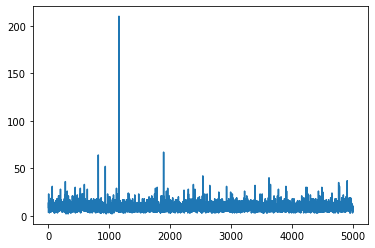

In [11]:
#clean source data/existing aritcles 
data = pd.read_pickle(data_path).reset_index()
Data = data[~(data[col2check].isna()) & (data[col2check].str.len()>20)].copy()
Data[col2check] = Data[col2check].apply(lambda title: textpp.clean_sentence(title,lower=False,stopwords=set(STOPWORDS)))
Data = Data[~(Data[col2check].isna()) & (Data[col2check].str.len()>20)].copy()
dtest = Data.head(5000)

#determine statistics of title length 
print(
'min',min([len(x) for x in dtest[col2check]]),
'max',max([len(x) for x in dtest[col2check]]),
'avg',np.mean([len(x) for x in dtest[col2check]]))
plt.plot([len(x.split()) for x in dtest[col2check]])

In [7]:
#truncate text to ensure consistent string length comparisons 
dtest[col2check] = dtest[col2check].apply(lambda x: x[:max_str_len])

#docs to process 
docs = dtest[col2check].copy()

#create default set of labels (index of the input data series)
#labels = [i for i in range(1,len(docs)+1)]
labels = [i for i in docs.index]

#create minhash model 
minhash = MinHash(docs, n_gram=n_gram, permutations=permutations, hash_bits = hash_bits, seed=seed)

#create lsh model 
#no_of_bands: higher results in more fps (default #permutations/2)
lsh = LSH(minhash, labels, no_of_bands=permutations/2)

In [15]:
docs.index

RangeIndex(start=0, stop=5000, step=1)

In [8]:
#get doc edge list 
print([item for item in lsh.adjacency_list().items() if item[1] !=[]][:10]) #adjacency list for text similarity graph
print([item for item in lsh.edge_list()][:10]) #edge list for tex similarity graph 

#query doc for similar docs 
print(lsh.query(1,min_jaccard=.4))



[(1, [5, 14, 31, 67, 76, 107, 347, 455, 472, 752, 795, 840, 873, 911, 928, 932, 987, 1041, 1152, 1156, 1221, 1269, 1331, 1335, 1403, 1420, 1457, 1796, 1809, 1940, 2011, 2053, 2077, 2253, 3139, 1212]), (2, [340, 1585]), (5, [1, 14, 31, 67, 76, 107, 347, 455, 472, 752, 795, 840, 873, 911, 928, 932, 987, 1041, 1152, 1156, 1221, 1269, 1331, 1335, 1403, 1420, 1457, 1796, 1809, 1940, 2011, 2053, 2077, 2253, 3139, 1212]), (7, [693, 2407, 3921, 4164, 4617, 4814]), (8, [516]), (9, [4792]), (13, [886, 4726, 4877]), (14, [1, 5, 31, 67, 76, 107, 347, 455, 472, 752, 795, 840, 873, 911, 928, 932, 987, 1041, 1152, 1156, 1221, 1269, 1331, 1335, 1403, 1420, 1457, 1796, 1809, 1940, 2011, 2053, 2077, 2253, 3139, 1212]), (15, [865, 1012, 104, 1280, 1558, 1885, 2307, 1425, 3014, 830]), (16, [719, 4411, 133, 374, 919, 1290, 1839, 2000, 2054, 2215, 2519, 2521, 2748, 3023, 3520, 3526, 4951, 4953, 33, 148, 778, 857, 1023, 1149, 1158, 1225, 1341, 1428, 1843, 1910, 2079, 2136, 2500, 2619, 2681, 2725, 2767, 3108,

In [87]:
#view similar articles 
#NOTICE: there are a lot of subgroups that contain overlapping 'similar articles' (i.e 1{2,3}, 3{4,5}) . in this example we can actually link 3 to both 1,2,4 and 5!
#print(dtest.loc[[1,5,16,33,71,81],'title'])
[dtest.loc[[values[0]]+values[1],'title'] for values in lsh.adjacency_list().items() if values[1]!=[]][:9]

[1       Mastering Google Search Operators in 67 Easy Steps                                
 5       Mastering Google Search Operators in 67 Easy Steps                                
 15      Mastering Google Search Operators in 67 Easy Steps                                
 32      Mastering Google Search Operators in 67 Easy Steps                                
 68      Mastering Google Search Operators in 67 Easy Steps                                
 77      Mastering Google Search Operators in 67 Easy Steps                                
 109     Mastering Google Search Operators in 67 Easy Steps                                
 354     Mastering Google Search Operators in 67 Easy Steps                                
 462     Mastering Google Search Operators in 67 Easy Steps                                
 479     Mastering Google Search Operators in 67 Easy Steps                                
 762     Mastering Google Search Operators in 67 Easy Steps                     

In [ ]:
###################CLUSTERING GRAPH OBJECTTS (NEXT STEPS)##############################

In [78]:
#CREATE AND CLUSTER GRAPH OBJECT 
from hcs_clustering.hcs import labelled_HCS
import numpy as np 
import networkx as nx

#1. Get edge list from lsh 
edges = lsh.edge_list(min_jaccard=.5, jaccard_weighted=True)

#2.create a graph object by passing a list of weighted edges to an empty graph objct 
FG = nx.Graph()
FG.add_weighted_edges_from(edges)

In [79]:
from hcs_clustering.hcs import create_example_graph
#test = create_example_graph()
#labels = labelled_HCS(FG)

In [80]:
E = nx.algorithms.connectivity.cuts.minimum_edge_cut(FG)
#_G = HCS(G)
#sub_graphs = nx.connected_component_subgraphs(GF)


NetworkXError: Input graph is not connected

In [81]:
#Analyzing Graph
for n, nbrs in FG.adj.items():
    for nbr, eattr in nbrs.items():
        wt = eattr['weight']
        if wt <= 0.5: print('(%d, %d, %.3f)' % (n, nbr, wt))
            
list(nx.connected_components(FG))
sorted(d for n, d in FG.degree())
nx.clustering(FG)

(4547, 3354, 0.500)
(3354, 4547, 0.500)
(4301, 3920, 0.500)
(224, 3920, 0.500)
(2901, 3920, 0.500)
(3872, 3920, 0.500)
(3920, 4301, 0.500)
(3920, 224, 0.500)
(3920, 2901, 0.500)
(3920, 3872, 0.500)
(4293, 3435, 0.500)
(3435, 4293, 0.500)
(4126, 2838, 0.500)
(2838, 4126, 0.500)
(4040, 3738, 0.500)
(3738, 4040, 0.500)
(3941, 2889, 0.500)
(2889, 3941, 0.500)
(3351, 1755, 0.500)
(1755, 3351, 0.500)
(2955, 1469, 0.500)
(2955, 2824, 0.500)
(456, 2824, 0.500)
(456, 1469, 0.500)
(594, 2824, 0.500)
(594, 1469, 0.500)
(1469, 2955, 0.500)
(1469, 2463, 0.500)
(1469, 456, 0.500)
(1469, 594, 0.500)
(2463, 2824, 0.500)
(2463, 1469, 0.500)
(2824, 2955, 0.500)
(2824, 456, 0.500)
(2824, 594, 0.500)
(2824, 2463, 0.500)
(2552, 2099, 0.500)
(1440, 2099, 0.500)
(2099, 2552, 0.500)
(2099, 1440, 0.500)
(2082, 477, 0.500)
(477, 2082, 0.500)
(1599, 1069, 0.500)
(1069, 1599, 0.500)
(1545, 295, 0.500)
(295, 1545, 0.500)


{4993: 0,
 3902: 0,
 4991: 0,
 4985: 0,
 4969: 1.0,
 1118: 1.0,
 3935: 1.0,
 4968: 1.0,
 3507: 1.0,
 4077: 1.0,
 4871: 1.0,
 4967: 1.0,
 92: 1.0,
 595: 1.0,
 2648: 1.0,
 4088: 1.0,
 4955: 1.0,
 3907: 1.0,
 4052: 1.0,
 4950: 1.0,
 2212: 1.0,
 3906: 1.0,
 4949: 0,
 3318: 0,
 4944: 1.0,
 393: 1.0,
 1395: 1.0,
 1762: 1.0,
 3898: 1.0,
 4943: 1.0,
 4799: 1.0,
 4935: 1.0,
 4941: 0,
 4477: 0,
 4934: 0,
 4512: 0,
 4918: 0,
 2406: 0,
 4917: 0,
 3640: 0,
 4900: 0,
 3925: 0,
 4877: 1.0,
 1341: 1.0,
 3921: 1.0,
 4873: 0,
 2875: 0,
 4870: 0,
 3765: 0,
 4860: 1.0,
 3511: 1.0,
 4278: 1.0,
 4858: 1.0,
 2660: 1.0,
 3799: 1.0,
 3822: 1.0,
 3914: 1.0,
 4092: 1.0,
 4855: 1.0,
 2251: 1.0,
 3900: 1.0,
 4854: 0,
 402: 0,
 4846: 0,
 3905: 0,
 4836: 1.0,
 4143: 1.0,
 4193: 1.0,
 4833: 1.0,
 2237: 1.0,
 2946: 1.0,
 3402: 1.0,
 3840: 1.0,
 4823: 0,
 3750: 0,
 4822: 1.0,
 1867: 1.0,
 2104: 1.0,
 4004: 1.0,
 4455: 1.0,
 4819: 1.0,
 2607: 1.0,
 4555: 1.0,
 4817: 1.0,
 1101: 1.0,
 2244: 1.0,
 2965: 1.0,
 2969: 1.0,
 

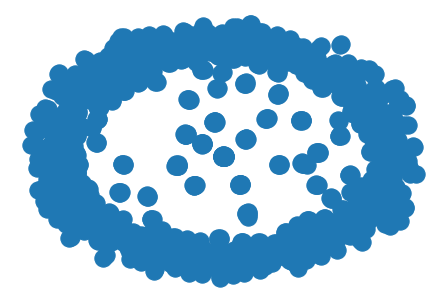

In [82]:
import matplotlib.pyplot as plt
nx.draw(FG,with_labels=False)

In [84]:
# Python program to print connected  
# components in an undirected graph 
class Graph: 
      
    # init function to declare class variables 
    def __init__(self,V): 
        self.V = V 
        self.adj = [[] for i in range(V)] 
  
    def DFSUtil(self, temp, v, visited): 
  
        # Mark the current vertex as visited 
        visited[v] = True
  
        # Store the vertex to list 
        temp.append(v) 
  
        # Repeat for all vertices adjacent 
        # to this vertex v 
        for i in self.adj[v]: 
            if visited[i] == False: 
                  
                # Update the list 
                temp = self.DFSUtil(temp, i, visited) 
        return temp 
  
    # method to add an undirected edge 
    def addEdge(self, v, w): 
        self.adj[v].append(w) 
        self.adj[w].append(v) 
  
    # Method to retrieve connected components 
    # in an undirected graph 
    def connectedComponents(self): 
        visited = [] 
        cc = [] 
        for i in range(self.V): 
            visited.append(False) 
        for v in range(self.V): 
            if visited[v] == False: 
                temp = [] 
                cc.append(self.DFSUtil(temp, v, visited)) 
        return cc 
  
# Driver Code 
if __name__=="__main__": 
      
    # Create a graph given in the above diagram 
    # 5 vertices numbered from 0 to 4 
    g = Graph(5); 
    g.addEdge(1, 0) 
    g.addEdge(2, 3) 
    g.addEdge(3, 4) 
    cc = g.connectedComponents() 
    print("Following are connected components") 
    print(cc) 
  
# This code is contributed by Abhishek Valsan  

Following are connected components
[[0, 1], [2, 3, 4]]


In [85]:
#CREATE AND CLUSTER GRAPH OBJECT 
from hcs_clustering.hcs import labelled_HCS
import numpy as np 
import networkx as nx

#1. Get edge list from lsh 
edges = lsh.edge_list(min_jaccard=.5, jaccard_weighted=False)

#2.create a graph object by passing a list of weighted edges to an empty graph objct 
g= Graph(len(labels))

for edge in edges:
    #print(edge)
    g.addEdge(edge[0],edge[1])

cc = g.connectedComponents()

In [86]:
cc
for _list in cc:
    print(dtest.loc[_list,'title'])
    

0    Brazil Espaco Cidadania 003
Name: title, dtype: object
1       Mastering Google Search Operators in 67 Easy Steps         
3178    Mastering Google Search Operators in 67 Easy Steps Moz Blog
1170    Mastering Google Search Operators in 67 Easy Steps Moz     
2280    Mastering Google Search Operators in 67 Easy Steps         
5       Mastering Google Search Operators in 67 Easy Steps         
2102    Mastering Google Search Operators in 67 Easy Steps         
15      Mastering Google Search Operators in 67 Easy Steps         
2078    Mastering Google Search Operators in 67 Easy Steps         
32      Mastering Google Search Operators in 67 Easy Steps         
2036    Mastering Google Search Operators in 67 Easy Steps         
68      Mastering Google Search Operators in 67 Easy Steps         
1965    Mastering Google Search Operators in 67 Easy Steps         
77      Mastering Google Search Operators in 67 Easy Steps         
1832    Mastering Google Search Operators in 67 Easy Ste

Name: title, dtype: object
278    Brennas Wing by WB Welch FREE
Name: title, dtype: object
279    Best Buy Shares Slip Amid Sluggish Sales Weak Outlook
Name: title, dtype: object
280     Swagbucks The March Referral Bonus Is Here               
2321    Earn More from Swagbucks The March Referral Bonus Is Here
Name: title, dtype: object
281    2017 Funnel Hacking Live Notes Premium by Tim Castleman Review Best Live Notes and Video Recording o
Name: title, dtype: object
282     Book Tour Cheater by Rachel Van Dyken
4585    Book Tour Cheater by Rachel Van Dyken
Name: title, dtype: object
283    Book Review TALK A Practical Approach to Cyberparenting and Open Communication
Name: title, dtype: object
284     Build a Website by waqasranag
2317    Build a Website by waqasranag
Name: title, dtype: object
285    Blood Phase by Kirsten Campbell
Name: title, dtype: object
286    Cybersecurity and labor conciliation
Name: title, dtype: object
287    International Business Development Manager
Name:

Name: title, dtype: object
562     Pursonic 100 Pure Essential Aromatherapy Oils Gift Set 11 95 Retail 29 99
2313    Pursonic 100 Pure Essential Aromatherapy Oils Gift Set 11 95 Retail 29 99
895     Pursonic 100 Pure Essential Aromatherapy Oils Gift Set 11 95 Retail 29 99
1566    Pursonic 100 Pure Essential Aromatherapy Oils Gift Set 11 95 Retail 29 99
986     Pursonic 100 Pure Essential Aromatherapy Oils Gift Set 11 95 Retail 29 99
Name: title, dtype: object
563    How to Babysit a Grandpa Hardcover for 7 99 with Free Prime Shipping Amazon
Name: title, dtype: object
564    6 Common Amazon Prime Video Problems Fixes
Name: title, dtype: object
565    In Farleigh Field by Rhys Bowen Giveaway US only
Name: title, dtype: object
566    17 Gotham Steel 9 5 Square Ultra Non Stick Frying Pan As Seen On TV via eBay
Name: title, dtype: object
568    Coming Soon Truly Madly Whiskey by Melissa Foster
Name: title, dtype: object
569    My Week of Reading 20 25 February 2017
Name: title, dtype: objec

Name: title, dtype: object
873    Coldhearted by Brooklyn Taylor
Name: title, dtype: object
874    How to Buy Kindle Books on iPhone or iPad
Name: title, dtype: object
875    The death of free speech Come on
Name: title, dtype: object
876    Check out Meteor from OpenSignal a new speedtest app for the average person
Name: title, dtype: object
879    42DD Sexy Euro Bella Mathure independent 5 7 Blue eyes Red hair Amazon figure and Big ass 42
Name: title, dtype: object
880    Amazon expands food delivery service
Name: title, dtype: object
881    Lucid Mattress Review
Name: title, dtype: object
882    Wal Mart Beats Earnings Estimates as Online Sales Surge
Name: title, dtype: object
883    A Seriously Lazy Puggle Dog DIY Vitamin Water Filet Table Online Grocery Deals and More
Name: title, dtype: object
884    Run Ride Cannock Chase Winter Classic 2017
Name: title, dtype: object
886    No youre not crazy Part of a internet broke
Name: title, dtype: object
889     JHBSJGUJKH 1866 936 3527 K

Name: title, dtype: object
1204    Amazon Crafty Deals on NOW
Name: title, dtype: object
1205    Amazons Spring Comedy Pilots Continue Amazons Take Risks Plan
3155    Amazons Spring Comedy Pilots Continue Amazons Take Risks Plan
Name: title, dtype: object
1206    Amazon Lizol Disinfectant For Cleaner Citrus 2 L worth Rs 300 at Rs 135 Only
4003    Amazon Lizol Disinfectant For Cleaner Citrus 2 L worth Rs 300 at Rs 135 Only
Name: title, dtype: object
1208    See Carries 10 Favorite Deals from Amazon
Name: title, dtype: object
1209    Review Sisters One Two Three by Nancy Star
Name: title, dtype: object
1210    How to Profit from Celgene CELG Options
4521    How to Profit from Celgene CELG Options
2748    How to Profit from Celgene CELG Options
Name: title, dtype: object
1211    AM225 Amazon Prime Now
Name: title, dtype: object
1213    RELEASE BLITZ LUCKY by CARINA ADAMS
2579    RELEASE BLITZ LUCKY by CARINA ADAMS
Name: title, dtype: object
1214    Amazon Web Services Outages Affects East

Name: title, dtype: object
1518    Targets Painful Lesson Low Prices Beat Hip Products
Name: title, dtype: object
1519    February Smorgasblog Deserted Lands Apocalyptic Books
Name: title, dtype: object
1520    Amazon cloud outage causes big disruption
Name: title, dtype: object
1521    Adata 10000mAh Power Bank PT100 Rs 799 Amazon
Name: title, dtype: object
1522    The Washington Post In Bed With CIA For Fake News
Name: title, dtype: object
1523    Cover Reveal Honor And Pride Guarding The Gods 2 by Ann Lister
Name: title, dtype: object
1525    When Amazon s cloud storage fails people get wet
Name: title, dtype: object
1526    Budgets not just for households
Name: title, dtype: object
1527    What We Love February Favorites
Name: title, dtype: object
1528    Wtb Moto Tcs 29 Mountain Tire Tires Amp Tubes Mountain Bike Tires
Name: title, dtype: object
1529    Audio Book Release HOOK S LITTLE MERMAID by Suzanna Lynn Giveaway Teaser
Name: title, dtype: object
1530    Secrets Of Growing Am

Name: title, dtype: object
1852    In South Africa what are we supposed to do away with when we decolonise the curriculum
Name: title, dtype: object
1853    Face The Beat session 4 has hit Spotify iTunes Amazon etc
Name: title, dtype: object
1854    The Empty Room by Sarah J Clemens Blog Tour and Giveaway
Name: title, dtype: object
1855    Morning Coffee 1 March 2017
Name: title, dtype: object
1857    Trailer Reveal SAVING MERCY by Abbie Roads
Name: title, dtype: object
1858    New Book Alert Daughter of a Thousand Years by Amalia Carosella
Name: title, dtype: object
1859    Into Shadow T D Shields Author
Name: title, dtype: object
1861    Buy Any Two Fire 7 inch Tablets Save 15
Name: title, dtype: object
1862    Google Alert pictures
Name: title, dtype: object
1863    At the Do Nut Hole Caf
Name: title, dtype: object
1865    House of Marley Smile Jamaica in ear headphones Review
Name: title, dtype: object
1866    NEW RELEASE GAME CHANGER SEATTLE STEEL HEADS FOOTBALL GAME ON IN SEATTLE

2186    Brainstorm Health Daily March 3 2017
Name: title, dtype: object
2187    Larabar Gluten Free Bar Chocolate Chip Cherry Torte 16 Count Only 11 60 Shipped
Name: title, dtype: object
2188    My press finally made its way in Haha as much as I enjoy this
Name: title, dtype: object
2189    Amazon to Host Networking Happy Hour and Tech Talk in Bellevue
Name: title, dtype: object
2190    Google Assistant gets ready for Android smartphones
Name: title, dtype: object
2191    MyIrelandBox Subscription Box Review Coupon January 2017
Name: title, dtype: object
2192    Portronics Sublime Ii Por 137 Portable Wireless Bluetooth Speaker Rs 1999 Amazon
Name: title, dtype: object
2194    Crazy Ex Girlfriend creator Rachel Bloom talks dream guest favorite song of the season
Name: title, dtype: object
2195    Software Sitemanpro Software
Name: title, dtype: object
2196    Meet the Author Exclusive Interview with the comedian Ms Joy Eileen Comic Romance Author
Name: title, dtype: object
2197    Amazo

Name: title, dtype: object
2515    Wreck It Ralph 2 Casts Ugly Bettys Ana Ortiz
Name: title, dtype: object
2516    Lumix GH5 vs Olympus EM1 II vs Fujifilm XT2 vs Sony A7s II 4k movie quality
Name: title, dtype: object
2517    Release Blitz Blind Faith by Nancy Haviland
Name: title, dtype: object
2518    4 Stocks To Watch Before The Market Opens Tomorrow Wednesday March 1
Name: title, dtype: object
2519    IWSG I Just Published My Second Book
Name: title, dtype: object
2520    Blitz DANGEROUS VICTOR by AISLINN KEARNS
Name: title, dtype: object
2521    Dirty Projectors Dirty Projectors Roundtable Review
Name: title, dtype: object
2522    Amazon Canada deal on 1 only Tumi International Rollaboard
Name: title, dtype: object
2523    JVZoo ClickBank Google YouTube 2 654 Today
Name: title, dtype: object
2524    Target has terrible holiday and warns of awful 2017
Name: title, dtype: object
2525    Release Blitz One Wrong Choice by A M Hargrove Terri E Laine
3232    Release Blitz One Wrong Choi

Name: title, dtype: object
2871    100 awesome Android apps that will turn your phone into a jack of all trades
Name: title, dtype: object
2872    What You Don t Know by JoAnn Chaney Book Review
Name: title, dtype: object
2873    Niagra Review Dont Buy Before You Read This
2959    ASOX9 Review Dont Buy Before You Read This 
Name: title, dtype: object
2874    3 Things I Learned Week 9
Name: title, dtype: object
2875    New Balance J4040V3 Youth Baseball Shoe Little Kid Big Kid Price 31 15 17 53
4873    New Balance J4040V3 Youth Baseball Shoe Little Kid Big Kid Price 31 15 17 53
Name: title, dtype: object
2877    Amazon Rainforest Was Shaped by an
Name: title, dtype: object
2878    Dealing with anxiety worry OCD and panic attacks in children
Name: title, dtype: object
2879    Eurasia Review Newsletter Crisis In The Mail Fixing A Broken International Package System Analysis
Name: title, dtype: object
2880    In the News Nimble Gets Funding Google Data Studio Offered for Free
3862    In th

Name: title, dtype: object
3199    Stacking the Shelves Sunday Post 3 4 17
Name: title, dtype: object
3200    Electric Pressure Washer with Hose Reel Only 149 88 Shipped Regularly 229 99
Name: title, dtype: object
3201    9 CPS California Kidnapping and Corruption
Name: title, dtype: object
3202    bluboo x zhu live set
Name: title, dtype: object
3203    Amazon might make Alexa home phone with intercoms
Name: title, dtype: object
3204    Movie Review Examining Live Free or Die Hard
Name: title, dtype: object
3206    Smartphone Buying Guide under Rs 20 000 March 2017
Name: title, dtype: object
3209    Top 10 Slim iPhone 7 Cases Oct 2016
Name: title, dtype: object
3210    Release Day Get Rocked in Vegas box set by 13 authors Giveaway
Name: title, dtype: object
3214    Tosaa Square Grill Pan 228mm Rs 379 Amazon
Name: title, dtype: object
3215    Review Blitz The Wright Brother by K A Linde
Name: title, dtype: object
3216    Chasing Casey by Jane Anthony
Name: title, dtype: object
3217    

3542    Two Pounds of Protein For 11 Plus More EAS Deals From Amazon
Name: title, dtype: object
3543    Legal Sniggy ft Konshens Official Music Video Head Concussion Records
Name: title, dtype: object
3544    12 Bottles of 20oz Gatorade Original Thirst Quencher Variety Pack 8 19 Free Shipping or 7 23 With 5 
Name: title, dtype: object
3545    Rihanna Inspired Lena Dunhams New Tit Chandelier Tattoo
Name: title, dtype: object
3546    New post The best selling Cuisinart 15 Piece Stainless Steel Knife Block Set is now only 35 shipped 
Name: title, dtype: object
3547    MIND The Message by Jenn Nixon
Name: title, dtype: object
3548    Spotify Has 30 Million More Paying Subscribers Than Apple Music
Name: title, dtype: object
3549    Her Secret Husband sundarivenkat
Name: title, dtype: object
3550    LG Signature OLED77W7P W7 Series OLED TV review
Name: title, dtype: object
3553    Amazon BIG Savings on Chemical Guys Car Care Products
Name: title, dtype: object
3554    Click Appeal Image Spli

3917    Jumbo Ziploc Flexible Tote For Just 2 86 3 20 Shipped Via Amazon Subscribe Save
Name: title, dtype: object
3918    2 key reasons why Foursquare s move to open up access to its location data is important
Name: title, dtype: object
3922    Step into spring and save 20 off new season fashion from Amazon with this discount code
Name: title, dtype: object
3923    DISTANT ILLUSIONS KENNEDY LAYNE COVER REVEAL
Name: title, dtype: object
3924    LIVE MORE BOSS by Juliana Conners
Name: title, dtype: object
3925    Hip2Saves Daily Recap of Deals 3 1 17
4900    Hip2Saves Daily Recap of Deals 3 1 17
Name: title, dtype: object
3926    This Slow Cooker Goat recipe makes amazing shredded beef chicken too
Name: title, dtype: object
3927    BioElectronics Initiates US Over the Counter Non Prescription Sales Of Its FDA Cleared Drug free Pai
Name: title, dtype: object
3928    Sunday Love KJ Lewis Release Blitz
Name: title, dtype: object
3929    Riggios World Barnes Noble Earnings Call
Name: title,

Name: title, dtype: object
4247    Apple iPhone 6 32GB variant goes on sale in India on Amazon for Rs 28999 iPhone 7 and 7 Plus get Rs 
Name: title, dtype: object
4248    Internets Major Reliance and What to Expect with iPhones Anniversary
Name: title, dtype: object
4250    Supreme Court Won t Hear Transgender Teen s Challenge To Bathroom Policy
Name: title, dtype: object
4251    Pre order updates 3 5 17
Name: title, dtype: object
4252    Dabur Red Tooth Paste Value pack 200g 100g free ToothBrush Rs 108
Name: title, dtype: object
4253    FIRST LOOK MEANT FOR YOU BY MICHELLE MAJOR
Name: title, dtype: object
4254    Buy online iBall 150 Mbps 150 M Wireless N Router iB WRB150N for Rs 699
Name: title, dtype: object
4255    Accessibility and the Web of Things an interview with Dr Scott Hollier and W3C WAIs Shadi Abou Zahra
Name: title, dtype: object
4256    Lead Web Developer Full stack Software Engineer
Name: title, dtype: object
4257    Simple Hydrating Cleansing Oil
Name: title, dtype: o

Name: title, dtype: object
4567    Amazon Buy Vim Dishwash Bar 3x200g at Rs 38
Name: title, dtype: object
4568    Free Writer Resources Roundup
Name: title, dtype: object
4569    Cats in Art The Stray Kitten Collins
Name: title, dtype: object
4570    Get 5 for Joining Swagbucks
Name: title, dtype: object
4571    Dark Web OSINT With Python and OnionScan Part One
4572    Dark Web OSINT With Python and OnionScan Part One
Name: title, dtype: object
4573    Leme Bluetooth 4 0 On Ear Headphones with Built In Mic EB20 for 14 99 Free Shipping LeMall com
Name: title, dtype: object
4574    Amazon hands over Echo data after gadget hears mans hot tub killing
Name: title, dtype: object
4575    Turner And Warner Bros Announce New Domestic Premium Streaming Service Boomerang Here Are Details
Name: title, dtype: object
4576    Turner Warner Bros Launch Cartoon Streaming Service
Name: title, dtype: object
4577    MAP Course at Michigan Ross Celebrates 25 Years of Hands On Learning
Name: title, dtype: o

Name: title, dtype: object
4866    The Future Of Work The Intersection Of Artificial Intelligence And Human Resources
Name: title, dtype: object
4867    WEDNESDAY ERIC SCHMIDT NEWS REVIEW
Name: title, dtype: object
4868    CREE Nutrition Review How Safe and Effective is this Product
Name: title, dtype: object
4869    Google Home could soon solve a big smart speaker problem
Name: title, dtype: object
4872    Direct Connect to the AWS Cloud
Name: title, dtype: object
4874    Twas the night before Switchmas
Name: title, dtype: object
4875    Book Review The Shadow Queen by C J Redwine
Name: title, dtype: object
4876    All Roads Lead to God
Name: title, dtype: object
4878    Cover Reveal I M ONLY HERE FOR THE BEARD by Lani Lynn Vale
Name: title, dtype: object
4879    New post Smartphone Accessories Mpow 3 3 Feet MFi Lightning to USB Cable 2 pack 10 Prime shipped Reg
Name: title, dtype: object
4880    New post Get younger glowing skin by using this facial cleansing brush for 28 Prime shipp